In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from statistics import mean
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
import shap

from sklearn.metrics import RocCurveDisplay

In [7]:
import shap


/Users/mark/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("/Users/mark/Library/CloudStorage/Box-Box/Projects/Crohns/sparc_dataset/231015_linear_model_features.csv")
df["Age"] =  pd.DatetimeIndex(df["SAMPLE_COLLECTED_DATE"]).year - df["BIRTH_YEAR"]
df = df.dropna(subset="DISEASE_ACTIVITY_60")
df = df.drop(["REQUESTED_FILE_NAME", "DEIDENTIFIED_MASTER_PATIENT_ID", "SAMPLE_COLLECTED_DATE", "BIRTH_YEAR"], axis=1)

In [46]:
df_encoded = df.replace({"Female":0, "Male":1, "Crohn's Disease":0, 'Ulcerative Colitis':1, "Remission":0, "Moderate":1, "Mild":2, "Severe":3})
df_encoded=df_encoded.fillna(df_encoded.mean(numeric_only=True))

y = df_encoded["DIAGNOSIS"]
X = df_encoded.loc[:, df_encoded.columns != 'DIAGNOSIS']



results = []

def helper(X_train, X_test, y_train, y_test, clf, seed, feature_set_name):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=predictions).ravel()
    return {"tn":tn, "tp":tp, "fp":fp, "fn":fn, "accuracy_score":accuracy_score(y_pred=predictions, y_true=y_test), "seed":seed, "feature_set":feature_set_name }


proteomcs_ttest = open("/Users/mark/Library/CloudStorage/Box-Box/Projects/Crohns/231015_features.txt", "r").read() .replace('\n', ' ').split(" ") 
proteomcs_ttest+["Age", "DISEASE_ACTIVITY_60", "SEX"]
prot=["Q9Y5Q6","P29460","O95750","P29459_P29460","P16422","P35228","Q99795","P04196","Q02747","P10144","P22455","P09238"]

prot_clin = ["Q9Y5Q6","P29460","O95750","P29459_P29460","P16422","P35228","Q99795","P04196","Q02747","P10144","P22455","P09238", "Age", "DISEASE_ACTIVITY_60", "SEX"]

print(df_encoded.describe)
X, X_validation, y, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

for seed in [42, 69, 7, 88, 30, 82, 51, 12, 24, 62,
             25, 23, 8, 31, 91, 99, 77, 60, 49, 13, 101, 222, 543, 230, 6969, 4242, 17, 19, 1234, 329, 39]:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    results.append(helper(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, clf=RandomForestClassifier(), seed=seed, feature_set_name="full"))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    results.append(helper(X_train=X_train[proteomcs_ttest], X_test=X_test[proteomcs_ttest], y_train=y_train, y_test=y_test, clf=RandomForestClassifier(), seed=seed, feature_set_name="proteomics_ttest"))

    X_train, X_test, y_train, y_test = train_test_split(X[prot_clin], y, test_size=0.3, random_state=seed)
    results.append(helper(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, clf=RandomForestClassifier(), seed=seed, feature_set_name="prot_clinical"))
    
    X_train, X_test, y_train, y_test = train_test_split(X[prot], y, test_size=0.3, random_state=seed)
    results.append(helper(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, clf=RandomForestClassifier(), seed=seed, feature_set_name="proteomics_only"))



results_df = pd.DataFrame(results)

print(results_df.head())

results_df.to_csv("/Users/mark/Library/CloudStorage/Box-Box/Projects/Crohns/240117_ml_feature_comparison.csv")



<bound method NDFrame.describe of       SEX  DIAGNOSIS  DISEASE_ACTIVITY_60  A0FGR8    A1E959  A1KZ92  A1L4H1  \
0       0          0                    1  5.3942  0.035200 -0.0215  1.2593   
1       0          1                    2  1.4847 -0.712000  0.3843  0.7300   
2       1          1                    1  5.8135 -0.877900 -0.7144  0.7910   
3       1          1                    2  3.6384  0.272936  0.1327  0.4326   
4       1          1                    1  5.7691  0.000100 -0.3014 -0.5161   
...   ...        ...                  ...     ...       ...     ...     ...   
1102    0          0                    2  3.7412 -0.759300  0.4203  0.3133   
1103    0          1                    2  4.4711 -1.767400 -0.5976  0.2612   
1104    1          1                    2  3.1606  0.329700 -0.0699  0.9786   
1105    0          1                    0  4.2287  0.507900  0.7691  0.5283   
1106    0          1                    0  4.1107  0.730800 -0.6829  0.6058   

        A2VDF0  A

In [21]:
train = X[prot_clin]
val = X_validation[prot_clin]
clf=RandomForestClassifier().fit(train, y)

explainer = shap.KernelExplainer(clf.predict_proba, val)
shap_values = explainer.shap_values(val)


Using 222 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 222/222 [08:43<00:00,  2.36s/it]


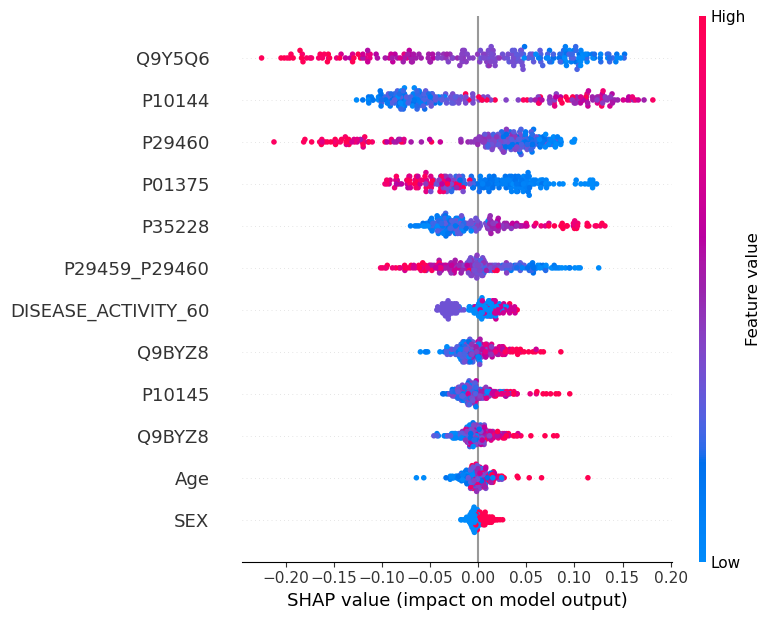

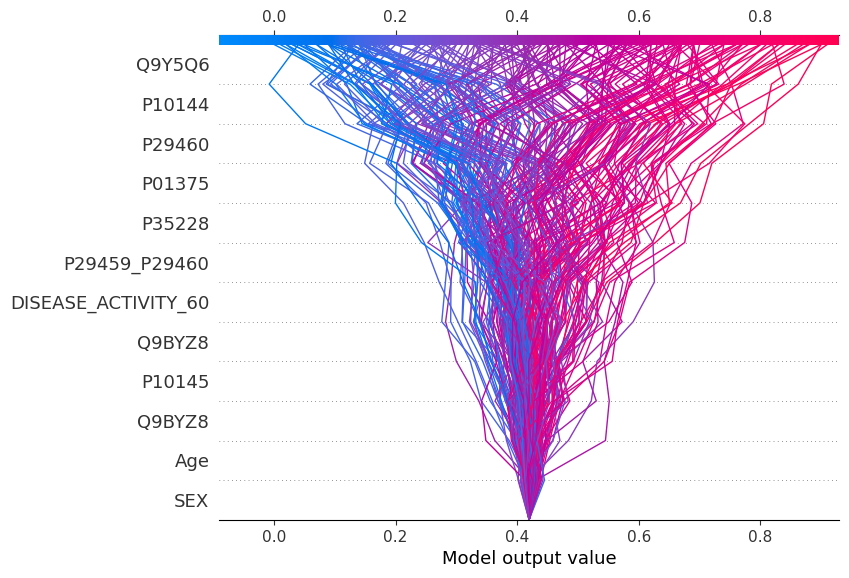

In [25]:
shap.summary_plot(shap_values[1], val)

shap.decision_plot(explainer.expected_value[1], shap_values[1], val.columns)


In [47]:

train = X[prot]
val = X_validation[prot]
clf=RandomForestClassifier().fit(train, y)

explainer = shap.KernelExplainer(clf.predict_proba, val)
shap_values = explainer.shap_values(val)


Using 222 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 222/222 [08:47<00:00,  2.38s/it]


(884, 12)


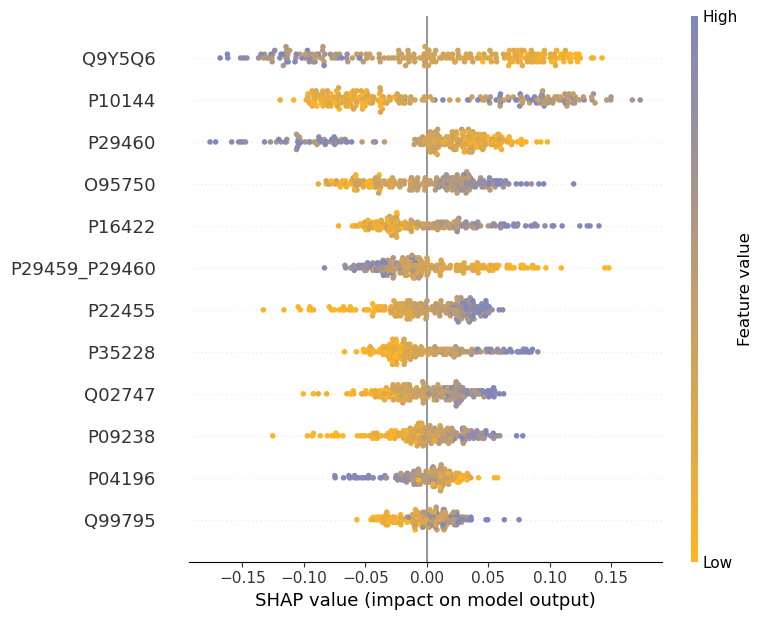

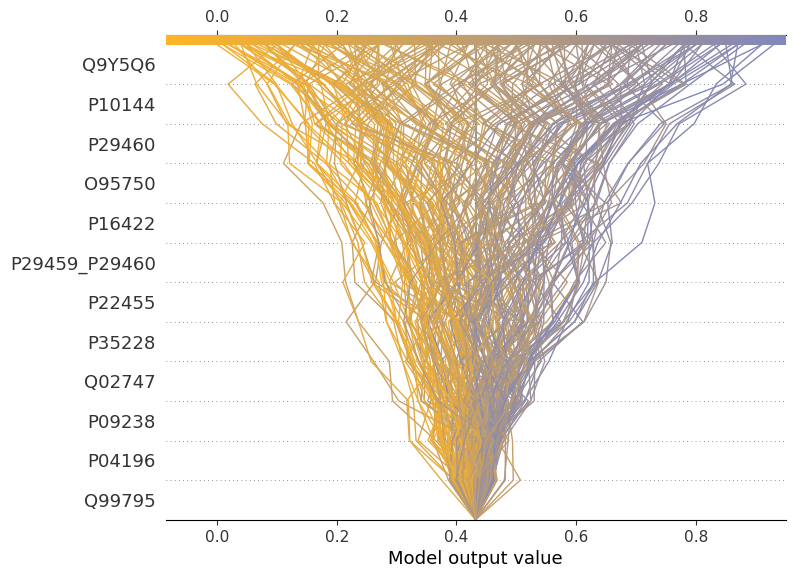

In [48]:
print(X[prot].shape)

from matplotlib.colors import LinearSegmentedColormap
newCmap = LinearSegmentedColormap.from_list("", ['#FEB424','#8087BC'])
shap.summary_plot(shap_values[1], val, cmap=newCmap)

shap.decision_plot(explainer.expected_value[1], shap_values[1], val.columns, plot_color=newCmap)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




clf = RandomForestClassifier()

param_grid = {

 'max_depth': [ 10, 20, 50, 70, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 800, 2000]
}
print(X_train.shape)
grid_clf = GridSearchCV(clf, param_grid, cv=10, n_jobs=8, verbose=1)
grid_clf.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, grid_clf.predict(X_test) ))
print("MCC: ",matthews_corrcoef(y_test, grid_clf.predict(X_test) ))

result = permutation_importance(
    grid_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8
)

feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

print(forest_importances.sort_values(ascending=False)[0:15])

(884, 2923)
Fitting 10 folds for each of 225 candidates, totalling 2250 fits
Accuracy: 0.6306306306306306
MCC:  0.2218286109115429


/Users/mark/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


P26639    0.008559
P10912    0.008108
P24821    0.008108
Q63HQ2    0.008108
O95750    0.008108
Q14773    0.006306
Q07011    0.005856
Q01151    0.004955
P33764    0.004955
P51580    0.004955
Q13316    0.004955
Q8NBZ7    0.004955
Q9NZP8    0.004505
O75711    0.004505
Q9H9E1    0.004505
dtype: float64


In [5]:
subset_features = open("/Users/mark/Library/CloudStorage/Box-Box/Projects/Crohns/231015_features.txt", "r").read() .replace('\n', ' ').split(" ") 


subset_X = X[subset_features]
subset_X.head()

X_train, X_test, y_train, y_test = train_test_split(subset_X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(884, 199)


In [6]:


clf = RandomForestClassifier()

param_grid = {

 'max_depth': [ 10, 20, 50, 70, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 800, 2000]
}

grid_clf = GridSearchCV(clf, param_grid, cv=10, n_jobs=8, verbose=1)
grid_clf.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, grid_clf.predict(X_test) ))
print("MCC: ",matthews_corrcoef(y_test, grid_clf.predict(X_test) ))


Fitting 10 folds for each of 225 candidates, totalling 2250 fits
Accuracy: 0.7747747747747747
MCC:  0.5361171794283707


In [7]:
result = permutation_importance(
    grid_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8
)

/Users/mark/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [8]:
feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

print(forest_importances.sort_values(ascending=False)[0:15])

P29460           0.023423
P35228           0.014865
Q02747           0.014414
P01375           0.013063
O95750           0.011261
Q9NPH0           0.010811
Q9Y5Q6           0.009459
Q2L4Q9           0.008559
P10144           0.008559
P29459_P29460    0.008559
P16422           0.008559
P01579           0.008108
Q15485           0.007207
P26010           0.007207
Q02817           0.006757
dtype: float64


In [9]:
mini_X = X[["P10145","P01375","P35228","Q9BYZ8","Age", "DISEASE_ACTIVITY_60", "SEX", "P29460", "Q9Y5Q6", "P10144", "P29459_P29460", "Q9BYZ8"]]

X_train, X_test, y_train, y_test = train_test_split(mini_X, y, test_size=0.2, random_state=42)
print(X_train.shape)
clf = RandomForestClassifier()

param_grid = {

 'max_depth': [ None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 400, 800, 1600, 2000]
}

grid_clf = GridSearchCV(clf, param_grid, cv=10, n_jobs=8, verbose=1)
grid_clf.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, grid_clf.predict(X_test) ))
print("MCC: ",matthews_corrcoef(y_test, grid_clf.predict(X_test) ))


result = permutation_importance(
    grid_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8
)

feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

print(forest_importances.sort_values(ascending=False))

(884, 12)
Fitting 10 folds for each of 63 candidates, totalling 630 fits
Accuracy: 0.7342342342342343
MCC:  0.45222405621338857
P29460                 0.072072
Q9Y5Q6                 0.058108
P10144                 0.041892
P29459_P29460          0.035135
P01375                 0.028829
Q9BYZ8                 0.024775
Q9BYZ8                 0.024775
P35228                 0.022523
P10145                 0.018018
DISEASE_ACTIVITY_60    0.013514
SEX                    0.001802
Age                   -0.000450
dtype: float64


In [10]:
mini_X = X[["P10145","P01375","P35228","Q9BYZ8", "P29460", "Q9Y5Q6", "P10144", "P29459_P29460", "Q9BYZ8"]]

X_train, X_test, y_train, y_test = train_test_split(mini_X, y, test_size=0.2, random_state=42)
print(X_train.shape)
clf = RandomForestClassifier()

param_grid = {

 'max_depth': [ None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 400, 800, 1600, 2000]
}

grid_clf = GridSearchCV(clf, param_grid, cv=10, n_jobs=8, verbose=1)
grid_clf.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, grid_clf.predict(X_test) ))
print("MCC: ",matthews_corrcoef(y_test, grid_clf.predict(X_test) ))


result = permutation_importance(
    grid_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8
)

feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

print(forest_importances.sort_values(ascending=False))

(884, 9)
Fitting 10 folds for each of 63 candidates, totalling 630 fits
Accuracy: 0.7297297297297297
MCC:  0.4453511425715907
P29460           0.063964
Q9Y5Q6           0.052252
P10144           0.048649
P29459_P29460    0.033333
P01375           0.027477
P35228           0.025676
P10145           0.009459
Q9BYZ8           0.009009
Q9BYZ8           0.009009
dtype: float64


In [11]:
print(X.head())

   SEX  DISEASE_ACTIVITY_60  A0FGR8    A1E959  A1KZ92  A1L4H1    A2VDF0  \
0    0                    1  5.3942  0.035200 -0.0215  1.2593  1.540100   
1    0                    2  1.4847 -0.712000  0.3843  0.7300  0.729600   
2    1                    1  5.8135 -0.877900 -0.7144  0.7910 -0.895600   
3    1                    2  3.6384  0.272936  0.1327  0.4326  0.134872   
4    1                    1  5.7691  0.000100 -0.3014 -0.5161  0.054200   

   A4D1B5  A6BM72    A6NC86  ...  Q9Y6D9    Q9Y6E0  Q9Y6I3  Q9Y6K9  Q9Y6N7  \
0  1.3128  0.4729  0.267700  ...  1.6570  4.297000 -0.0009  4.8749  0.2925   
1  0.3499 -0.0206  0.950700  ...  0.4633  2.306200 -0.4170  1.5862  0.1015   
2 -0.4804 -0.1077 -1.109000  ...  0.0769  4.274700  0.1532  4.2024 -0.4867   
3 -0.1485  0.3700 -0.283201  ...  2.1361  2.510842  0.9694  4.5522  1.2974   
4  1.4471  0.2667 -0.566700  ...  1.5091  4.100000  0.6958  4.7955 -0.1609   

   Q9Y6Q6  Q9Y6U3  Q9Y6X8  Q9Y6Y9  Age  
0  0.8393  0.7011  0.7768  0.6368   40 

In [6]:

#Using the bonferoni features + demo data
subset_features = open("/Users/mark/Library/CloudStorage/Box-Box/Projects/Crohns/sparc_dataset/2312016_bonferoni_hits.txt", "r").read() .replace('\n', ' ').split(" ") 
print(subset_features)

subset_X = X[subset_features+["Age", "SEX", "DISEASE_ACTIVITY_60"]]
subset_X.head()

X_train, X_test, y_train, y_test = train_test_split(subset_X, y, test_size=0.2, random_state=42)
print(X_train.shape)
clf = RandomForestClassifier()

param_grid = {

 'max_depth': [ None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 400, 800, 1600, 2000]
}

grid_clf = GridSearchCV(clf, param_grid, cv=10, n_jobs=8, verbose=1)
grid_clf.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, grid_clf.predict(X_test) ))
print("MCC: ",matthews_corrcoef(y_test, grid_clf.predict(X_test) ))


result = permutation_importance(
    grid_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8
)

feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

print(forest_importances.sort_values(ascending=False))

['Q9Y5Q6', 'P29460', 'O95750', 'P29459_P29460', 'P16422', 'P35228', 'Q99795', 'P04196', 'Q02747', 'P10144', 'P22455', 'P09238', 'Q9Y6Y9']
(884, 16)
Fitting 10 folds for each of 63 candidates, totalling 630 fits
Accuracy: 0.7387387387387387
MCC:  0.46386227412951864
P29460                 0.045946
Q9Y6Y9                 0.030180
P29459_P29460          0.021622
P10144                 0.018919
P16422                 0.013063
Q02747                 0.012613
P35228                 0.007658
P22455                 0.006757
P04196                 0.005405
Age                    0.005405
Q99795                 0.004955
SEX                    0.004955
P09238                 0.004505
O95750                 0.002703
Q9Y5Q6                 0.002252
DISEASE_ACTIVITY_60   -0.000901
dtype: float64


In [5]:

#Using the bonferoni features without demo data
subset_features = open("/Users/mark/Library/CloudStorage/Box-Box/Projects/Crohns/sparc_dataset/2312016_bonferoni_hits.txt", "r").read() .replace('\n', ' ').split(" ") 
print(subset_features)

subset_X = X[subset_features]
subset_X.head()

X_train, X_test, y_train, y_test = train_test_split(subset_X, y, test_size=0.2, random_state=42)
print(X_train.shape)
clf = RandomForestClassifier()

param_grid = {

 'max_depth': [ None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 200, 400, 800, 1600, 2000]
}

grid_clf = GridSearchCV(clf, param_grid, cv=10, n_jobs=8, verbose=1)
grid_clf.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, grid_clf.predict(X_test) ))
print("MCC: ",matthews_corrcoef(y_test, grid_clf.predict(X_test) ))


result = permutation_importance(
    grid_clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=8
)

feature_names = [X_train.columns[i] for i in range(X_train.shape[1])]
forest_importances = pd.Series(result.importances_mean, index=feature_names)

print(forest_importances.sort_values(ascending=False))



['Q9Y5Q6', 'P29460', 'O95750', 'P29459_P29460', 'P16422', 'P35228', 'Q99795', 'P04196', 'Q02747', 'P10144', 'P22455', 'P09238', 'Q9Y6Y9']
(884, 13)
Fitting 10 folds for each of 63 candidates, totalling 630 fits
Accuracy: 0.7432432432432432
MCC:  0.4725971079818067
P29460           0.051802
Q9Y6Y9           0.034234
P29459_P29460    0.022523
P16422           0.018919
P10144           0.016216
O95750           0.011712
P09238           0.007658
Q02747           0.006757
P22455           0.006306
P04196           0.006306
P35228           0.005405
Q99795          -0.004505
Q9Y5Q6          -0.006306
dtype: float64


In [44]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
#class ID is 1 for UC
y_predictions=grid_clf.predict(X_test)



tn, fp, fn, tp = confusion_matrix(y_test, y_predictions).ravel()

(tn, fp, fn, tp)
print(f1_score(y_test, y_predictions, average=None))


fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predictions, pos_label=1)
print(metrics.auc(fpr, tpr))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predictions, pos_label=0)
print(metrics.auc(fpr, tpr))

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- A0FGR8
- A1E959
- A1KZ92
- A1L4H1
- A2VDF0
- ...
